# Геморное домашнее задание №1

<img src='https://i0.wp.com/media4.giphy.com/media/AlBHDuku3H7fG/giphy.gif'><br>

# Загрузка данных

In [509]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, iqr
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import geopy
from sklearn.preprocessing import OrdinalEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hw-multiclass-classification/sub_baseline.csv
/kaggle/input/hw-multiclass-classification/train.csv
/kaggle/input/hw-multiclass-classification/test.csv
/kaggle/input/dataset-with-district/test_with_district.csv
/kaggle/input/dataset-with-district/train_with_district.csv
/kaggle/input/district/nyc_zip_borough_neighborhoods_pop.csv
/kaggle/input/ny-map/nyu_2451_34204.dbf
/kaggle/input/ny-map/nyu_2451_34204.shp
/kaggle/input/ny-map/nyu_2451_34204.cst
/kaggle/input/ny-map/wfsrequest.txt
/kaggle/input/ny-map/nyu_2451_34204.shx
/kaggle/input/ny-map/nyu_2451_34204.prj


In [510]:
train = pd.read_csv('/kaggle/input/hw-multiclass-classification/train.csv', sep=';')
test = pd.read_csv('/kaggle/input/hw-multiclass-classification/test.csv', sep=';')
submission = pd.read_csv('/kaggle/input/hw-multiclass-classification/sub_baseline.csv')

In [511]:
'train: ', train.shape, 'test: ', test.shape, 'submission: ', submission.shape

('train: ', (39481, 15), 'test: ', (9871, 14))

In [ ]:
submission.head()

Результат нужно сохранить в **csv файл с двумя колонками**: 

listing_id - берете из датасета

interest_level - проставляете своим алгоритмом

Разделитель **запятая**, при сохранении с помощью result.to_csv() - не забывайте указывать index=None.

## Анализ данных
## 1. Предобработка и генерация признаков

Для выполнения задания попробуйте придумать признаки на основе имеющихся данных, для работы с текстовыми полями вам может пригодится LabelEncoder/OneHotEncoder, re.sub(),re.findall() 

Ниже представлены имеющиеся у нас признаки. Можно попробовать сгенерировать из них новые. Например, можно сделать признак Стоимость за комнату, признаки на основе значений в features, выделить и закодировать адрес, так же можно попробовать оценить "успешность" менеджера, предположив, что чем больше объявлений у данного manager_id - тем он круче.

In [512]:
train.head()

bathrooms  bedrooms                       building_id              created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2  2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd  2016-05-26 05:44:12   
2        1.0         0                                 0  2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703  2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444  2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                   ['Cats Allowed', 'Dogs Allowed']   40.6969     7097709   
1                                                 []   40.7264     7071860   
2        ['Doorman', 'Dogs Allowed', 'Cats Allowed']   40.7466     7174524   
3  ['Swimming Pool', 'Roof Deck', 'Dining Room', ...   40.7610     7104515   
4            ['Doorman', 'Fitness Center', 'No Fee']   40.7324     6859942   

   longitude                        manager_id  \
0   -73.9830  79d1809d224bc7f26c719f247d6c8dc6   
1   -74.0013  e60b02e0cfd2eea7d777bb283d6f8d4d   
2   -73.9779  91a276fdb4c7ae5ff56fd0884b5121db   
3   -73.9992  cbcd513212d592e6c717d27be14f46ac   
4   -74.0081  b209e2c4384a64cc307c26759ee0c651   

                                              photos  price  \
0  ['https://photos.renthop.com/2/7097709_8f74305...   2575   
1  ['https://photos.renthop.com/2/7071860_32b196a...   3250   
2  ['https://photos.renthop.com/2/7174524_bde8df9...   2448   
3  ['https://photos.renthop.com/2/7104515_bab0753...   3300   
4  ['https://photos.renthop.com/2/6859942_16f88f7...   5450   

         street_address interest_level  
0       257 Gold Street            low  
1   128 Thompson Street           high  
2  165 East 35th Street            low  
3  610 West 42nd Street            low  
4  666 Greenwich Street            low

In [513]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

In [514]:
train.interest_level.value_counts()

low       27446
medium     8941
high       3094
Name: interest_level, dtype: int64

**Строки превращаем обратно в список**

In [515]:
train.features

0                         ['Cats Allowed', 'Dogs Allowed']
1                                                       []
2              ['Doorman', 'Dogs Allowed', 'Cats Allowed']
3        ['Swimming Pool', 'Roof Deck', 'Dining Room', ...
4                  ['Doorman', 'Fitness Center', 'No Fee']
                               ...                        
39476                     ['Dogs Allowed', 'Cats Allowed']
39477    ['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...
39478                       ['Elevator', 'Fitness Center']
39479    ['Pre-War', 'Laundry in Unit', 'Dishwasher', '...
39480    ['Doorman', 'Fitness Center', 'Elevator', 'Sto...
Name: features, Length: 39481, dtype: object

Тут добавила lowspace т.к. записи немного отличаются

In [516]:
train['features']=train['features'].str.lower().str.replace('[\[\]\']', '', regex=True).str.split(', ')

In [517]:
train['features']

0                             [cats allowed, dogs allowed]
1                                                       []
2                    [doorman, dogs allowed, cats allowed]
3        [swimming pool, roof deck, dining room, doorma...
4                        [doorman, fitness center, no fee]
                               ...                        
39476                         [dogs allowed, cats allowed]
39477    [swimming pool, doorman, elevator, fitness cen...
39478                           [elevator, fitness center]
39479    [pre-war, laundry in unit, dishwasher, hardwoo...
39480    [doorman, fitness center, elevator, storage, p...
Name: features, Length: 39481, dtype: object

In [518]:
train['num_features']=train['features'].apply(len)

Фотографии можно спарсить по ссылкам, но т.к. обработка изображений в этой домашке не в приоритете, можно просто посчитать количество фотографий.

In [519]:
train['photos']=train['photos'].str.replace('[\[\]\']', '', regex=True).str.split(', ')
train['num_photos']=train['photos'].apply(len)

Делаем самые простые фичи. В данном случае просто считаем кол-во слов в описании.

В датасете присутствуют NaN, поэтому предварительно заполняем пропуски пустыми строками.

In [520]:
train["num_description_words"]=train["description"].fillna('').apply(lambda x: len(x.split(" ")))

Может быть заинтересованность объявлением зависит от времени года или времени публикации?

In [521]:
train["created"]

0        2016-06-02 04:21:46
1        2016-05-26 05:44:12
2        2016-06-17 01:22:32
3        2016-06-03 05:26:40
4        2016-04-12 04:10:28
                ...         
39476    2016-06-20 18:09:47
39477    2016-04-26 05:40:27
39478    2016-04-10 03:20:09
39479    2016-06-03 03:53:35
39480    2016-06-15 02:29:10
Name: created, Length: 39481, dtype: object

In [522]:
train["created"] = pd.to_datetime(train["created"])
train["created_year"] = train["created"].dt.year
train["created_month"] = train["created"].dt.month
train["created_day"] = train["created"].dt.day
train["created_hour"] = train["created"].dt.hour

<AxesSubplot:xlabel='index'>

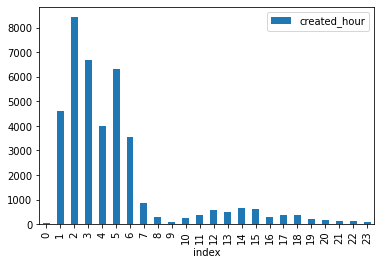

In [523]:
hours=train["created_hour"].value_counts().reset_index().sort_values(by='index')
hours.plot(x='index', y='created_hour', kind='bar')

не похоже что стоит использовать created_month в модели

<AxesSubplot:xlabel='index'>

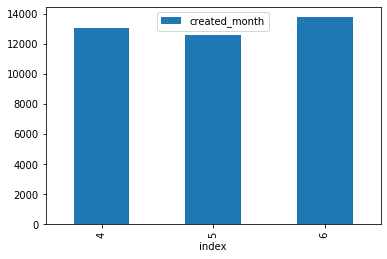

In [524]:
months=train["created_month"].value_counts().reset_index().sort_values(by='index')
months.plot(x='index', y='created_month', kind='bar')

In [525]:
mapper={'low':0, 'medium':1, 'high':2}
train['interest_level'] = train['interest_level'].apply(lambda x: mapper[x])

Добавляем признаки из features, создавая для каждого признака отдельный столбец

In [526]:
features_l = []
for feature in train.features:
    for j in range(len(feature)):
        features_l.append(feature[j])

In [527]:
features_set = set()
for feature in features_l:
    if feature not in features_set:
        if features_l.count(feature) > 1974: # пусть признак должен быть в минимум 5% выборки
            features_set.add(feature)

features_set.remove('')

In [528]:
def find(f):
    if feature in f:
        return 1
    else:
        return 0

In [529]:
for feature in features_set:
    train[feature] = train.features.apply(lambda f: find(f))

т.к. есть похожие по смыслу значения, но немного по разному написанные, поправила, что смогла найти 

In [530]:
def find_name(f, list_name):
    if f in list_name:
        return 1
    else:
        return 0

In [531]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'num_features', 'num_photos', 'num_description_words', 'created_year',
       'created_month', 'created_day', 'created_hour', 'new construction',
       'dogs allowed', 'high speed internet', 'elevator', 'pre-war',
       'laundry in unit', 'fitness center', 'cats allowed', 'doorman',
       'hardwood floors', 'swimming pool', 'balcony', 'dining room',
       'dishwasher', 'roof deck', 'outdoor space', 'laundry in building',
       'no fee'],
      dtype='object')

In [532]:
laundry = ['laundry in building', 'laundry in unit', 'laundry']
train['laundry in building'] = train.features.apply(lambda f: find_name(f, laundry))
elevator = ['elevator', 'elevators']
train['elevator'] = train.features.apply(lambda f: find_name(f, elevator))
doorman = ['doorman', 'door man']
train['doorman'] = train.features.apply(lambda f: find_name(f, doorman))
hardwood = ['hardwood', 'hard wood', 'hardwood floors']
train['hardwood floors'] = train.features.apply(lambda f: find_name(f, hardwood))

In [533]:
train = train.drop(['features', 'street_address', 'description', 'created', 'created_year',
                    'created_month', 'listing_id', 'photos', 'created_day',
                    'laundry in unit'], axis=1)

In [534]:
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)

Создаем новые признаки по популярности улиц/застройщиков/менеджеров

In [535]:
def get_dict(value_dict):
    i = 1
    value_dict = dict(reversed(list(value_dict.items())))
    for key, value in value_dict.items():
        if value > i:
            i += 1
            value_dict[key] = i
    return value_dict

In [536]:
building_dict = get_dict(train.building_id.value_counts().to_dict())
train['building_value'] = train.building_id.apply(lambda f: building_dict[f])
street_dict = get_dict(train.display_address.value_counts().to_dict())
train['street_value'] = train.display_address.apply(lambda f: street_dict[f])
manager_dict = get_dict(train.manager_id.value_counts().to_dict())
train['manager_value'] = train.manager_id.apply(lambda f: manager_dict[f])

In [537]:
train = train.drop(['display_address', 'building_id', 'manager_id'], axis=1)

Удаляю выбросы

In [538]:
feature_z = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']
z = np.abs(zscore(train[feature_z]))
train[feature_z] = train[feature_z][(z<3).all(axis=1)]

In [539]:
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)

In [540]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38383 entries, 0 to 38382
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathrooms              38383 non-null  float64
 1   bedrooms               38383 non-null  float64
 2   latitude               38383 non-null  float64
 3   longitude              38383 non-null  float64
 4   price                  38383 non-null  float64
 5   interest_level         38383 non-null  int64  
 6   num_features           38383 non-null  int64  
 7   num_photos             38383 non-null  int64  
 8   num_description_words  38383 non-null  int64  
 9   created_hour           38383 non-null  int64  
 10  new construction       38383 non-null  int64  
 11  dogs allowed           38383 non-null  int64  
 12  high speed internet    38383 non-null  int64  
 13  elevator               38383 non-null  int64  
 14  pre-war                38383 non-null  int64  
 15  fi

Добавим столбец с отношением комнат и ванн, по скольку квартиры с большим количеством комнат, но с малым количеством ванн, по моему мнению, имеют меньшую популярность

In [541]:
train['bb'] = (train['bedrooms']/train['bathrooms']).replace(np.inf, 0).fillna(0)

In [542]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38383 entries, 0 to 38382
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathrooms              38383 non-null  float64
 1   bedrooms               38383 non-null  float64
 2   latitude               38383 non-null  float64
 3   longitude              38383 non-null  float64
 4   price                  38383 non-null  float64
 5   interest_level         38383 non-null  int64  
 6   num_features           38383 non-null  int64  
 7   num_photos             38383 non-null  int64  
 8   num_description_words  38383 non-null  int64  
 9   created_hour           38383 non-null  int64  
 10  new construction       38383 non-null  int64  
 11  dogs allowed           38383 non-null  int64  
 12  high speed internet    38383 non-null  int64  
 13  elevator               38383 non-null  int64  
 14  pre-war                38383 non-null  int64  
 15  fi

<AxesSubplot:>

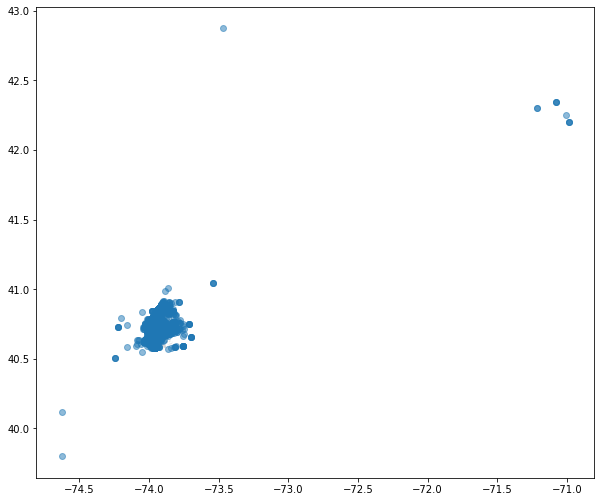

In [543]:
loc_crs = CRS("EPSG:28992")
loc_geom = [Point(xy) for xy in zip(train['longitude'], train['latitude'])]
geo_df = gpd.GeoDataFrame(train, crs=loc_crs, geometry=loc_geom)
shape_df = gpd.read_file('/kaggle/input/ny-map/nyu_2451_34204.shp')
fig, ax = plt.subplots(figsize=(10,10))
shape_df.plot(ax=ax, color='lightgrey', zorder=1)
geo_df.plot(ax=ax, alpha=0.5, zorder=2)

Дополнительно другим способом удалим выбросы для лучшей визуализации карты

In [544]:
feature_z = ['latitude', 'longitude']
Q1 = train[feature_z].quantile(q=.25)
Q3 = train[feature_z].quantile(q=.75)
IQR = train[feature_z].apply(iqr)
train_for_map = train[['latitude', 'longitude', 'interest_level']].copy()
train_for_map[feature_z] = train[feature_z][~((train[feature_z] < (Q1-1.5*IQR)) | (train[feature_z] > (Q3+1.5*IQR))).any(axis=1)]
train_for_map.dropna(inplace=True)
train_for_map.reset_index(drop=True, inplace=True)

In [545]:
train0 = train_for_map.loc[train_for_map.interest_level == 0]
train1 = train_for_map.loc[train_for_map.interest_level == 1]
train2 = train_for_map.loc[train_for_map.interest_level == 2]

In [546]:
loc_geom0 = [Point(xy) for xy in zip(train0['longitude'], train0['latitude'])]
geo_df0 = gpd.GeoDataFrame(train0, crs=loc_crs, geometry=loc_geom0)
loc_geom1 = [Point(xy) for xy in zip(train1['longitude'], train1['latitude'])]
geo_df1 = gpd.GeoDataFrame(train1, crs=loc_crs, geometry=loc_geom1)
loc_geom2 = [Point(xy) for xy in zip(train2['longitude'], train2['latitude'])]
geo_df2 = gpd.GeoDataFrame(train2, crs=loc_crs, geometry=loc_geom2)

<AxesSubplot:>

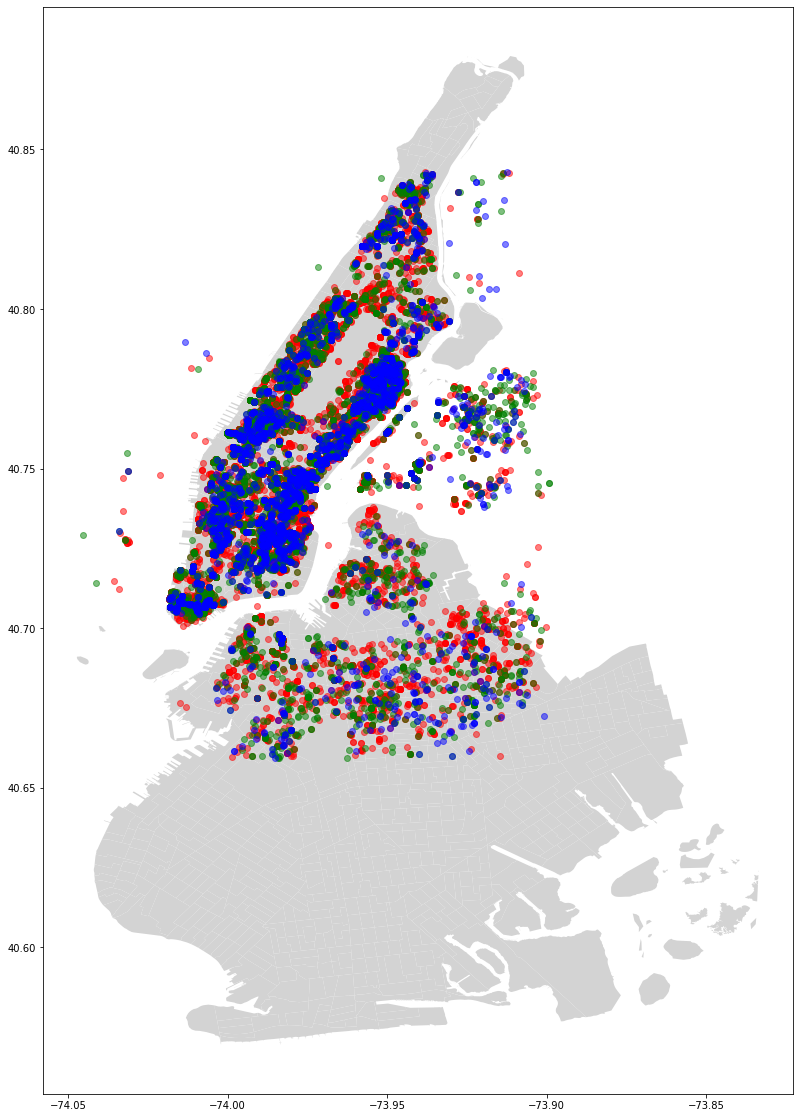

In [547]:
shape_df = gpd.read_file('/kaggle/input/ny-map/nyu_2451_34204.shp')
fig, ax = plt.subplots(figsize=(20,20))
shape_df.plot(ax=ax, color='lightgrey', zorder=1)
geo_df0.plot(ax=ax, alpha=0.5, zorder=2, color='red') #low
geo_df1.plot(ax=ax, alpha=0.5, zorder=2, color='green')
geo_df2.plot(ax=ax, alpha=0.5, zorder=2, color='blue') #high

In [548]:
district = pd.read_csv('/kaggle/input/district/nyc_zip_borough_neighborhoods_pop.csv')

In [549]:
district.head()

zip    borough   post_office         neighborhood  population  density
0  10001  Manhattan  New York, NY  Chelsea and Clinton       21102    33959
1  10002  Manhattan  New York, NY      Lower East Side       81410    92573
2  10003  Manhattan  New York, NY      Lower East Side       56024    97188
3  10004  Manhattan  New York, NY      Lower Manhattan        3089     5519
4  10005  Manhattan  New York, NY      Lower Manhattan        7135    97048

In [550]:
district_dict = dict(zip(district.zip, district.borough))

Ниже реализовано нахождение zip кодов, чтобы потом определить в каком районе города находится квартира.
Но т.к. это заняло примерно 4 часа, я сохранила dataframe с районами и все дальнейшие действия будут уже с ним

In [551]:
geolocator = geopy.Nominatim(user_agent='check_1')

In [552]:
def get_zip_code(x):
    try:
        location = geolocator.reverse('{}, {}'.format(x['latitude'],x['longitude']))
        return location.raw['address']['postcode']
    except KeyError:
        pass

Для всего дата фрейма надо 4 часа, поэтому оставила реализацию для первых 5 строк

In [553]:
#train['zipcode'] = train[['longitude', 'latitude']].apply(lambda x: get_zip_code(x), axis = 1)

In [554]:
train_5_row = train.head().copy()
train_5_row['zipcode'] = train_5_row[['longitude', 'latitude']].apply(lambda x: get_zip_code(x), axis = 1)

In [555]:
train_5_row

bathrooms  bedrooms  latitude  longitude   price  interest_level  \
0        1.0       0.0   40.6969   -73.9830  2575.0               0   
1        1.0       2.0   40.7264   -74.0013  3250.0               2   
2        1.0       0.0   40.7466   -73.9779  2448.0               0   
3        1.0       1.0   40.7610   -73.9992  3300.0               0   
4        2.0       0.0   40.7324   -74.0081  5450.0               0   

   num_features  num_photos  num_description_words  created_hour  ...  \
0             2          10                    381             4  ...   
1             1           5                     19             5  ...   
2             3           1                     86             1  ...   
3            16           6                    131             5  ...   
4             3           8                     81             4  ...   

   roof deck  outdoor space  laundry in building  no fee  building_value  \
0          0              0                    0       0              51   
1          0              0                    0       0               4   
2          0              0                    0       0             112   
3          1              1                    0       1              43   
4          0              0                    0       1              36   

   street_value  manager_value   bb                geometry  zipcode  
0           133              3  0.0  POINT (-73.983 40.697)    11201  
1           109              9  2.0  POINT (-74.001 40.726)    10012  
2           117             35  0.0  POINT (-73.978 40.747)    10016  
3           122             30  1.0  POINT (-73.999 40.761)    10036  
4            72            123  0.0  POINT (-74.008 40.732)    10014  

[5 rows x 33 columns]

In [556]:
train_5_row['zipcode'].fillna(train_5_row['zipcode'].mode()[0], inplace=True)

In [557]:
def get_district(f):
    try:
        return district_dict[int(f)]
    except KeyError:
        pass

In [558]:
#train['district'] = train.zipcode.apply(lambda f: get_district(f))
train_5_row['district'] = train_5_row.zipcode.apply(lambda f: get_district(f))

In [559]:
train_5_row.district.value_counts()

Manhattan    4
Brooklyn     1
Name: district, dtype: int64

In [560]:
#train['district'].fillna(train['district'].mode()[0], inplace=True)
train_5_row['district'].fillna(train_5_row['district'].mode()[0], inplace=True)

In [561]:
encoder = OrdinalEncoder()
#train[['district']] = pd.DataFrame(encoder.fit_transform(train[['district']]), columns=['district'])
train_5_row[['district']] = pd.DataFrame(encoder.fit_transform(train_5_row[['district']]), columns=['district'])

In [562]:
train_5_row.head()

bathrooms  bedrooms  latitude  longitude   price  interest_level  \
0        1.0       0.0   40.6969   -73.9830  2575.0               0   
1        1.0       2.0   40.7264   -74.0013  3250.0               2   
2        1.0       0.0   40.7466   -73.9779  2448.0               0   
3        1.0       1.0   40.7610   -73.9992  3300.0               0   
4        2.0       0.0   40.7324   -74.0081  5450.0               0   

   num_features  num_photos  num_description_words  created_hour  ...  \
0             2          10                    381             4  ...   
1             1           5                     19             5  ...   
2             3           1                     86             1  ...   
3            16           6                    131             5  ...   
4             3           8                     81             4  ...   

   outdoor space  laundry in building  no fee  building_value  street_value  \
0              0                    0       0              51           133   
1              0                    0       0               4           109   
2              0                    0       0             112           117   
3              1                    0       1              43           122   
4              0                    0       1              36            72   

   manager_value   bb                geometry  zipcode  district  
0              3  0.0  POINT (-73.983 40.697)    11201       0.0  
1              9  2.0  POINT (-74.001 40.726)    10012       1.0  
2             35  0.0  POINT (-73.978 40.747)    10016       1.0  
3             30  1.0  POINT (-73.999 40.761)    10036       1.0  
4            123  0.0  POINT (-74.008 40.732)    10014       1.0  

[5 rows x 34 columns]

In [563]:
#train.to_csv('/kaggle/working/train_with_district.csv', index=None)

In [564]:
#train = pd.read_csv('/kaggle/input/dataset-with-district/train_with_district.csv')

In [565]:
X = train.drop(['interest_level', 'geometry'], axis=1)
y = train.interest_level

In [566]:
X.head()

bathrooms  bedrooms  latitude  longitude   price  num_features  num_photos  \
0        1.0       0.0   40.6969   -73.9830  2575.0             2          10   
1        1.0       2.0   40.7264   -74.0013  3250.0             1           5   
2        1.0       0.0   40.7466   -73.9779  2448.0             3           1   
3        1.0       1.0   40.7610   -73.9992  3300.0            16           6   
4        2.0       0.0   40.7324   -74.0081  5450.0             3           8   

   num_description_words  created_hour  new construction  ...  dining room  \
0                    381             4                 0  ...            0   
1                     19             5                 0  ...            0   
2                     86             1                 0  ...            0   
3                    131             5                 1  ...            1   
4                     81             4                 0  ...            0   

   dishwasher  roof deck  outdoor space  laundry in building  no fee  \
0           0          0              0                    0       0   
1           0          0              0                    0       0   
2           0          0              0                    0       0   
3           1          1              1                    0       1   
4           0          0              0                    0       1   

   building_value  street_value  manager_value   bb  
0              51           133              3  0.0  
1               4           109              9  2.0  
2             112           117             35  0.0  
3              43           122             30  1.0  
4              36            72            123  0.0  

[5 rows x 30 columns]

## 2. Тестирование различных алгоритмов

Для выполнения этой части задания разбейте размеченные данные на train и test и напишите автоматическое тестирование разных алгоритмов классификации в цикле с вычислением метрики f1_score('macro')

Метрику на тесте по разным алгоритмам сохраняйте в датафрейм или выводите

In [567]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.cluster import Birch
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif

In [568]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Изменяйте параметры алгоритмов на свое усмотрение, можете добавлять свои алгоритмы

In [569]:
classifiers = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'RandomForestClassifier': RandomForestClassifier(),
    'MLPClassifier': MLPClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier(),
    'CatBoostClassifier': CatBoostClassifier(loss_function='MultiClass')
}

In [570]:
for name, clf in classifiers.items():
    print(name)
    if name != 'CatBoostClassifier':
        clf.fit(X, y)
    else:
        clf.fit(X, y, verbose=False)
    y_pred = clf.predict(X_test)
    print('На отложенной тестовой выборке: ')
    print('%s: F_мера = %7.5f' % (name, f1_score(y_test, y_pred, average='macro')))
    print('-'*30)

AdaBoostClassifier
На отложенной тестовой выборке: 
AdaBoostClassifier: F_мера = 0.48421
------------------------------
GaussianNB
На отложенной тестовой выборке: 
GaussianNB: F_мера = 0.42663
------------------------------
LogisticRegression
На отложенной тестовой выборке: 
LogisticRegression: F_мера = 0.37601
------------------------------
RandomForestClassifier
На отложенной тестовой выборке: 
RandomForestClassifier: F_мера = 0.98633
------------------------------
MLPClassifier
На отложенной тестовой выборке: 
MLPClassifier: F_мера = 0.39831
------------------------------
XGBClassifier
На отложенной тестовой выборке: 
XGBClassifier: F_мера = 0.76515
------------------------------
LGBMClassifier
На отложенной тестовой выборке: 
LGBMClassifier: F_мера = 0.64710
------------------------------
CatBoostClassifier
На отложенной тестовой выборке: 
CatBoostClassifier: F_мера = 0.71468
------------------------------


## 3. Отбор признаков

[Отбор признаков](https://scikit-learn.org/stable/modules/feature_selection.html)

[Recursive feature elimination](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py)

[SelectKBest + chi2](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

[L1-based feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)

[ExtraTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn.tree.ExtraTreeClassifier)

На выбор попробуйте выбрать самые важные признаки как минимум двумя разными способами (можно использовать те что выше или свой). Сравните способы по метрике f1 и average precision на тесте полученной делением размеченного файла.

In [571]:
X_new = SelectKBest(f_classif, k=20).fit_transform(X, y)
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 16 17 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [572]:
model = CatBoostClassifier(loss_function='MultiClass')
model.fit(X_train_new, y_train, verbose=False)
y_pred = model.predict(X_test_new)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))

F_мера =  0.5381446153913035


In [573]:
model = RandomForestClassifier()
model.fit(X, y)
model = SelectFromModel(model, prefit=True)
X_new = model.transform(X)
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [574]:
model = CatBoostClassifier(loss_function='MultiClass')
model.fit(X_train_new, y_train, verbose=False)
y_pred = model.predict(X_test_new)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))

F_мера =  0.4988336646771779


Все результаты хуже первоначального

## 4. Подбор гиперпараметров

Для этого задания подберите гиперпараметры как минимум для 3 алгоритмов из протестированных выше. Используйте Grid Search или Random Search, в качестве метрики передавайте f1_score

Не забывайте разбивать выборку на фолды, например с помощью StratifiedShuffleSplit.

Пришлось сделать всего 3 итераци и в кросс валидации разбиение всего на 3, иначе долго считает

In [575]:
dt = XGBClassifier()
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=3, cv=3, scoring='f1_macro')
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))
print(random_search.best_estimator_)
print(random_search.best_params_)

F_мера =  0.5622243777646923
XGBClassifier(base_score=1, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=1, ...)
{'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 500, 'learning_rate': 0.05, 'base_score': 1}


In [576]:
dt = LGBMClassifier()
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [6, 8, 12, 16],
    'boosting_type' : ['gbdt', 'dart']
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=3, cv=3, scoring='f1_macro')
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))
print(random_search.best_estimator_)
print(random_search.best_params_)

F_мера =  0.5407908279746568
LGBMClassifier(boosting_type='dart', n_estimators=500, num_leaves=16)
{'num_leaves': 16, 'n_estimators': 500, 'learning_rate': 0.1, 'boosting_type': 'dart'}


In [577]:
dt = CatBoostClassifier(loss_function='MultiClass', iterations=100)
params = {
    'learning_rate': [0.001, 0.01, 0.004],
    'depth': [5, 7, 9, 11],
    'l2_leaf_reg': [ 1.0, 5.0, 0.5],
    'min_child_samples': [1, 4, 8, 16, 32]
}
random_search = RandomizedSearchCV(dt, param_distributions=params, n_iter=3, cv=3, scoring='f1_macro')
random_search.fit(X_train, y_train, verbose=False)
y_pred = random_search.predict(X_test)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))
print(random_search.best_estimator_)
print(random_search.best_params_)

F_мера =  0.3252106105223346
{'min_child_samples': 8, 'learning_rate': 0.01, 'l2_leaf_reg': 0.5, 'depth': 5}


## 5. Стэкинг алгоритмов

Для выполнения этой части задания реализуйте стэкинг нечетного числа алгоритмов (больше одного конечно).

[Voting classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

[Stacked-generalization](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

In [578]:
clf1 = XGBClassifier()
clf2 = LGBMClassifier()
clf3 = RandomForestClassifier()
eclf = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2), ('clf3', clf3)])
eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))

F_мера =  0.5496281450257572


## 6. Добавление номера кластера в качестве признака

Сделать кластеризацию данных хотя бы на числовых признаках, кластер добавить к данным в качестве признака и обучить на этом классификатор.

Сравнить метрику с кластером-признаком и без.

При использовании k-means нужно сделать подбор количества кластеров одним из способов The Elbow Method или The Silhouette Method. [Как же это сделать в питоне](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

In [579]:
model = Birch()
X['cluster'] = model.fit_predict(X)

In [580]:
X.cluster.value_counts()

0    29274
1     8670
2      439
Name: cluster, dtype: int64

In [581]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [582]:
clf = CatBoostClassifier(loss_function='MultiClass')
clf.fit(X_train, y_train, verbose=False)
y_pred = clf.predict(X_test)
print('F_мера = ', (f1_score(y_test, y_pred, average='macro')))

F_мера =  0.4988336646771779


## 7. Итоговое решение и сабмит 

Далее должно приводиться ваше итоговое решение, с лучшей метрикой на лидерборде, которой вам удалось добится. Можете сделать два ноутбука если так удобнее.

Выше произведенные действия не гарантируют хороший результат на лидерборде, для него нужно поэксперементировать самостоятельно ;) 

**! ВАЖНО: ваш итоговый результат должен быть как минимум выше baseline.**

In [583]:
X = X.drop(['cluster'], axis=1)

In [584]:
clf = CatBoostClassifier(loss_function='MultiClass')
clf.fit(X, y, verbose=False)

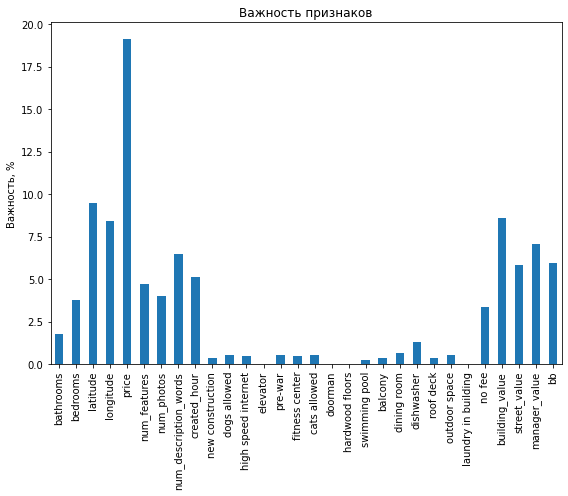

In [585]:
cat = pd.Series(clf.get_feature_importance(), X.columns)
fig, ax = plt.subplots(figsize=(8,7))
cat.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [586]:
clf.get_feature_importance()

array([ 1.74365092,  3.74385244,  9.46406541,  8.40106906, 19.13749649,
        4.67951984,  4.0024991 ,  6.49589884,  5.14609462,  0.34756475,
        0.54585399,  0.49854309,  0.        ,  0.552274  ,  0.45960582,
        0.5616509 ,  0.        ,  0.        ,  0.2613616 ,  0.34025615,
        0.64045233,  1.28270994,  0.35220656,  0.54823145,  0.        ,
        3.38303756,  8.60140284,  5.85018291,  7.03148529,  5.92903412])

In [587]:
X.columns

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'num_features', 'num_photos', 'num_description_words', 'created_hour',
       'new construction', 'dogs allowed', 'high speed internet', 'elevator',
       'pre-war', 'fitness center', 'cats allowed', 'doorman',
       'hardwood floors', 'swimming pool', 'balcony', 'dining room',
       'dishwasher', 'roof deck', 'outdoor space', 'laundry in building',
       'no fee', 'building_value', 'street_value', 'manager_value', 'bb'],
      dtype='object')

Удаляю признаки с важностью меньше 0,8

In [588]:
X = X.drop(['swimming pool', 'balcony', 'outdoor space', 'high speed internet', 'elevator',
            'cats allowed', 'dogs allowed', 'new construction', 'fitness center', 'dining room',
            'doorman', 'roof deck', 'pre-war', 'hardwood floors', 'laundry in building'], axis=1)

In [589]:
model = Birch()
X['cluster'] = model.fit_predict(X)

In [590]:
clf = CatBoostClassifier(loss_function='MultiClass')
clf.fit(X, y, verbose=False)

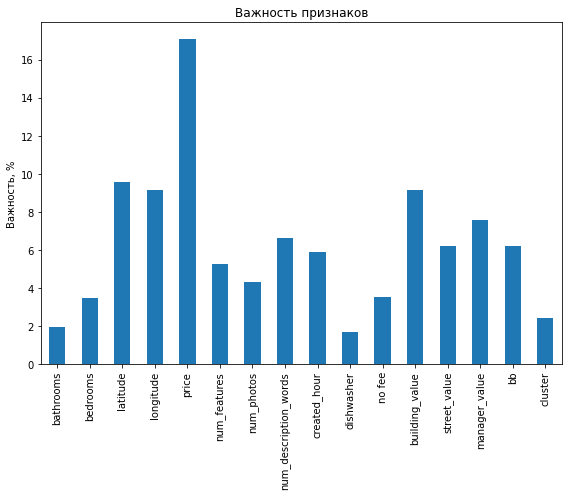

In [591]:
cat = pd.Series(clf.get_feature_importance(), X.columns)
fig, ax = plt.subplots(figsize=(8,7))
cat.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## Подготовка submission

В плане предобработки\генерации признаков делаем все тоже самое. Потом предсказываем моделью значения.

In [607]:
test = pd.read_csv('/kaggle/input/hw-multiclass-classification/test.csv', sep=';')

In [608]:
test['features']=test['features'].str.replace('[\[\]\']', '').str.split(', ')
test['num_features']=test['features'].apply(len)
test['photos']=test['photos'].str.replace('[\[\]\']', '').str.split(', ')
test['num_photos']=test['photos'].apply(len)
test["num_description_words"]=test["description"].fillna('').apply(lambda x: len(x.split(" ")))
test["created"] = pd.to_datetime(test["created"])
test["created_hour"] = test["created"].dt.hour

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Ниже реализовано получение zip кодов, для определения района, как и в train

In [609]:
#test['zipcode'] = test[['longitude', 'latitude']].apply(lambda x: get_zip_code(x), axis = 1)
#test['zipcode'].fillna(test['zipcode'].mode()[0], inplace=True)
#test['district'] = test.zipcode.apply(lambda f: get_district(f))
#test['district'].fillna(test['district'].mode()[0], inplace=True)
#test[['district']] = pd.DataFrame(encoder.fit_transform(test[['district']]), columns=['district'])

Получение признаков из features, отдельно для каждого признака свой столбец

In [610]:
for feature in features_set:
    test[feature] = test.features.apply(lambda f: find(f))

Дальше, казалось бы, надо сделать получение building_value, street_value и manager_value через словари, полученные на трейне (реализация закомменчена ниже). Но итоговый скор тогда выходит хуже, чем если сделать новую градацию "популярности" улиц/id только на тесте, что в моем понимании не совсем правильно, по скольку одни и те же id и улицы будут иметь разные значения на трейне и тесте. Но раз оно работает, не могу не воспользоваться, чтобы выбить скор по больше :)

In [611]:
#def get_dict_for_test(f, feature_for_dict):
#    try:
#        return feature_for_dict[f]
#    except KeyError:
#        pass

In [612]:
#test['building_value'] = test.building_id.apply(lambda f: get_dict_for_test(f, building_dict)).fillna(train['building_value'].mode()[0])
#test['street_value'] = test.display_address.apply(lambda f: get_dict_for_test(f, street_dict)).fillna(train['street_value'].mode()[0])
#test['manager_value'] = test.manager_id.apply(lambda f: get_dict_for_test(f, manager_dict)).fillna(train['manager_value'].mode()[0])

In [613]:
train2 = pd.read_csv('/kaggle/input/hw-multiclass-classification/train.csv', sep=';')

In [614]:
building_dict = get_dict(test.building_id.value_counts().to_dict())
test['building_value'] = test.building_id.apply(lambda f: building_dict[f])
street_dict = get_dict(test.display_address.value_counts().to_dict())
test['street_value'] = test.display_address.fillna(train2.display_address.mode()[0]).apply(lambda f: street_dict[f])
manager_dict = get_dict(test.manager_id.value_counts().to_dict())
test['manager_value'] = test.manager_id.apply(lambda f: manager_dict[f])

In [615]:
#test.to_csv('/kaggle/working/test_with_district.csv', index=None)

In [616]:
test['bb'] = (test['bedrooms']/test['bathrooms']).replace(np.inf, 0).fillna(0)

In [617]:
test = test.drop(['features', 'display_address', 'street_address', 'description', 'created',
                  'building_id', 'manager_id', 'photos', 'swimming pool', 'balcony',
                  'outdoor space', 'high speed internet', 'elevator', 'cats allowed',
                  'dogs allowed', 'new construction', 'fitness center', 'dining room', 'doorman',
                  'roof deck', 'pre-war', 'hardwood floors', 'laundry in building',
                  'laundry in unit'], axis=1)

In [618]:
test['cluster'] = model.predict(test.drop(['listing_id'], axis=1))
test['interest_level'] = clf.predict(test.drop(['listing_id'], axis=1))

In [620]:
test[['listing_id', 'interest_level']].to_csv('/kaggle/working/submission.csv', index=None)

### В итоге лучший результат показала модель на датасете без дистриктов :(